# Transfer learning with data augmentation

[Transfer learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a) is a powerful technique that allows sophisticated convolutional neural networks (CNNs) trained by Google, Microsoft, and others on GPUs to be repurposed and used to solve domain-specific problems. With transfer learning, for example, you can take a CNN trained to distinguish between dogs and cats and modify it to distinguish between hot dogs and hambugers. And you can do it on a typical PC or laptop computer — no GPU required.

Many pretrained CNNs are available in the public domain, and several are included with Keras. In this exercise, you will use Keras and Microsoft's [ResNet-50V2](https://keras.io/api/applications/resnet/#resnet50v2-function) pretrained CNN to build a network that distinguishes with a high degree of accuracy between images containing Arctic foxes, polar bears, and walruses. In an effort to increase the network's ability to generalize, you will include several image-preprocessing layers to randomly flip, rotate, translate, and scale the training images in each training epoch, a technique known as *data augmentation*.

![](Images/wildlife.png)

## Load training and testing images

The first step is to load the images that will be used for training and testing and to label the images with 0 for Arctic foxes, 1 for polar bears, and 2 for walruses. We'll start by defining a function for loading images from the file system and affixing labels to them, and another function for displaying images. We will also define four Python lists to hold the images used for training and testing (`x_train` and `x_test`) and the labels used for training and testing (`y_train` and `y_test`).

In [1]:
import os
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

def load_images_from_path(path, label):
    images = []
    labels = []

    for file in os.listdir(path):
        img = image.load_img(os.path.join(path, file), target_size=(224, 224, 3))
        images.append(image.img_to_array(img))
        labels.append((label))
        
    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

x_train = []
y_train = []
x_test = []
y_test = []

Load Arctic-fox training images and show the first few.

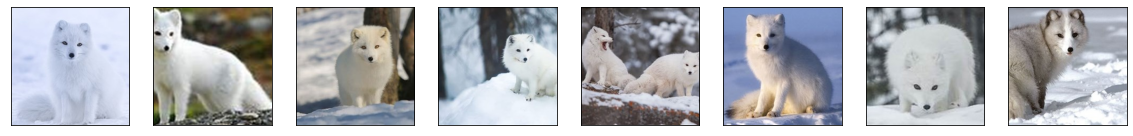

In [2]:
images, labels = load_images_from_path('Data/train/arctic_fox', 0)
show_images(images)
    
x_train += images
y_train += labels

Load polar-bear training images.

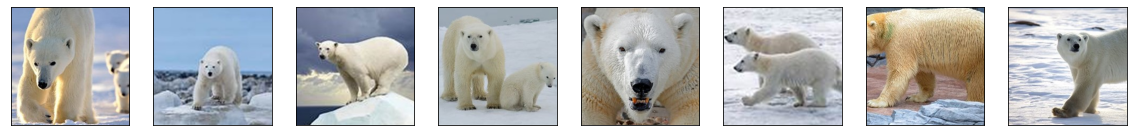

In [3]:
images, labels = load_images_from_path('Data/train/polar_bear', 1)
show_images(images)
    
x_train += images
y_train += labels

Load walrus training images.

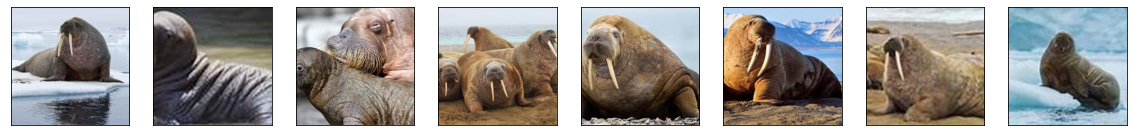

In [4]:
images, labels = load_images_from_path('Data/train/walrus', 2)
show_images(images)
    
x_train += images
y_train += labels

Now load Arctic-fox test images and show the first few.

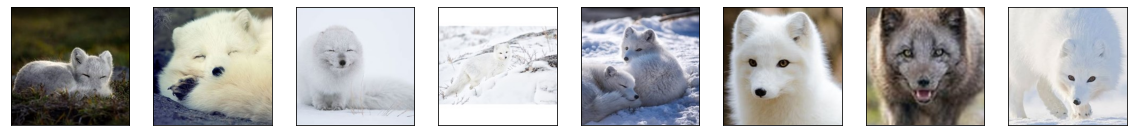

In [5]:
images, labels = load_images_from_path('Data/test/arctic_fox', 0)
show_images(images)
    
x_test += images
y_test += labels

Load polar-bear test images.

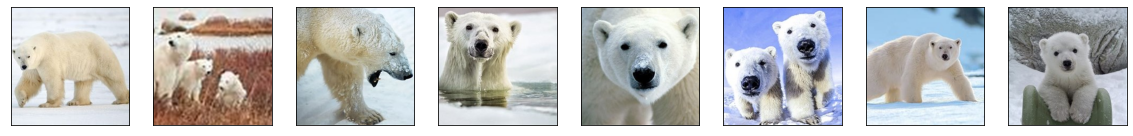

In [6]:
images, labels = load_images_from_path('Data/test/polar_bear', 1)
show_images(images)
    
x_test += images
y_test += labels

Load walrus test images.

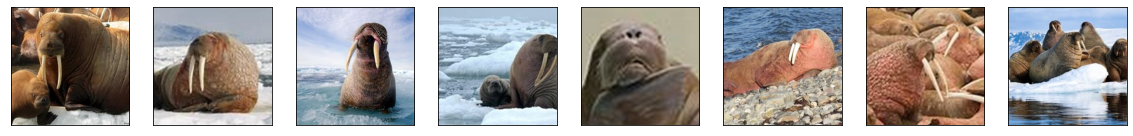

In [7]:
images, labels = load_images_from_path('Data/test/walrus', 2)
show_images(images)
    
x_test += images
y_test += labels

Preprocess the training and testing images, and use Keras's [`to_categorical`](https://keras.io/api/utils/python_utils/#to_categorical-function) function to one-hot-encode the training and testing labels. The images must be preprocessed the same way the images used to train ResNet-50V2 were preprocessed. This is accomplished by passing them to the `preprocess_input` function. There is no need to divide the pixel values by 255 because we will include a [Rescaling](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/#rescaling-class) layer in our network to do that.

In [8]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input

x_train = preprocess_input(np.array(x_train))
x_test = preprocess_input(np.array(x_test))
    
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

## Train a network based on ResNet-50V2 with data augmentation

Rather than create a CNN of our own, we will load ResNet-50V2 minus the classification layers and initialize it with the weights arrived at when it was trained on the [ImageNet](http://www.image-net.org/) dataset. We will then define a network that contains a series of image-preprocessing layers, ResNet-50V2's bottleneck layers, and our own classification layers, in that order. We will also prevent the bottleneck layers from training when the network is trained by setting their `Trainable` attributes to False. Begin by loading ResNet-50V2 minus the classification layers and freezing the layers.

In [9]:
from tensorflow.keras.applications import ResNet50V2

base_model = ResNet50V2(weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = False

Now define a network that incoroporates rescaling and augmentation layers, ResNet-50V2's bottleneck layers, and classification layers, and train the network. Also include a `Dropout` layer to help the network generalize.

In [10]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom

model = Sequential()
model.add(Rescaling(1./255))
model.add(RandomFlip(mode='horizontal'))
model.add(RandomTranslation(0.2, 0.2))
model.add(RandomRotation(0.2))
model.add(RandomZoom(0.2))
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist = model.fit(x_train, y_train_encoded, validation_data=(x_test, y_test_encoded), batch_size=10, epochs=25)

Epoch 1/25
30/30 [==============================] - 31s 527ms/step - loss: 20.9985 - accuracy: 0.6548 - val_loss: 7.0154 - val_accuracy: 0.9417
Epoch 2/25
30/30 [==============================] - 15s 493ms/step - loss: 11.5772 - accuracy: 0.8530 - val_loss: 6.3217 - val_accuracy: 0.9667
Epoch 3/25
30/30 [==============================] - 15s 495ms/step - loss: 6.5654 - accuracy: 0.8783 - val_loss: 5.5323 - val_accuracy: 0.9333
Epoch 4/25
30/30 [==============================] - 15s 495ms/step - loss: 3.6633 - accuracy: 0.9265 - val_loss: 3.1466 - val_accuracy: 0.9583
Epoch 5/25
30/30 [==============================] - 15s 504ms/step - loss: 1.6908 - accuracy: 0.9503 - val_loss: 2.4075 - val_accuracy: 0.9750
Epoch 6/25
30/30 [==============================] - 15s 498ms/step - loss: 3.6426 - accuracy: 0.9304 - val_loss: 2.4109 - val_accuracy: 0.9667
Epoch 7/25
30/30 [==============================] - 15s 490ms/step - loss: 2.2058 - accuracy: 0.9394 - val_loss: 2.1634 - val_accuracy: 0.95

How well did the network train? Let's plot the training accuracy and validation accuracy for each epoch.

[]

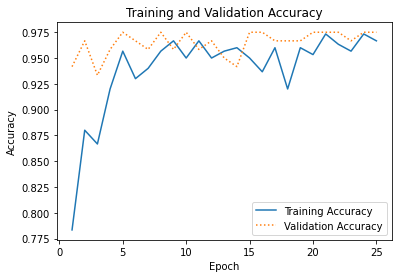

In [11]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Use a confusion matrix to visualize how well the network performed during testing.

Text(89.18, 0.5, 'Actual label')

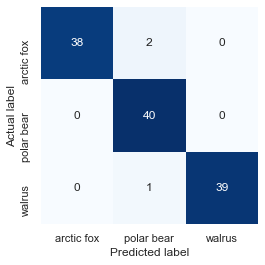

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set()

y_predicted = model.predict(x_test)
mat = confusion_matrix(y_test_encoded.argmax(axis=1), y_predicted.argmax(axis=1))
class_labels = ['arctic fox', 'polar bear', 'walrus']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

## Make a prediction

What happens if the network is used to classify an image that it hasn't seen before? And how do you go about making such a prediction? Let's take an Arctic-fox image that the network was neither trained nor tested with and see how the network classifies it. The first step is to load the image.

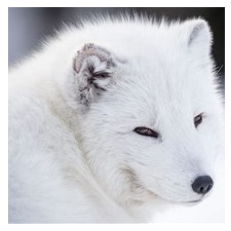

In [13]:
x = image.load_img('Data/samples/arctic_fox/arctic_fox_140.jpeg', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

Preprocess the image and submit it to the network for classification.

In [14]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
predictions = model.predict(x)

for i, label in enumerate(class_labels):
    print(f'{label}: {predictions[0][i]}')

arctic fox: 1.0
polar bear: 0.0
walrus: 0.0


Now try it with a walrus image that the network hasn't seen before. Start by loading the image.

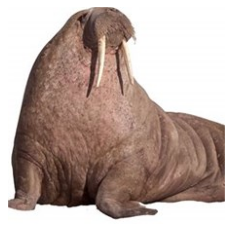

In [15]:
x = image.load_img('Data/samples/walrus/walrus_143.png', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

Preprocess the image and make a prediction.

In [16]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
predictions = model.predict(x)

for i, label in enumerate(class_labels):
    print(f'{label}: {predictions[0][i]}')

arctic fox: 0.0
polar bear: 0.0
walrus: 1.0


ResNet-50V2 wasn't trained to recognize walruses, but our network was.